In [1]:
import pandas as pd
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
from nltk.metrics import distance
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
def show(x):
    print(x.shape)
    return x.head()

In [3]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(56746, 6)


,paper_id,internal_reference_id,reference_id,context,start_offset,end_offset
0,0,1,1,Our approach is mainly based on the BERT langu...,56,59
1,0,8,444,Different from many other ranking methods whic...,216,219
2,0,5,163,"Moreover, for full ranking subtask, we use a s...",78,81
3,0,6,26,The proposed model is based on the pointer-gen...,59,62
4,0,6,26,"Following [7], we also use a soft switch to ch...",10,13


In [4]:
references = pd.read_csv("../data/references.csv")
show(references)

(24921, 4)


,reference_id,title,original_citations,abstract
0,0,Distributed Representations of Words and Phras...,172,The recently introduced continuous Skip-gram m...
1,1,BERT: Pre-training of Deep Bidirectional Trans...,167,We introduce a new language representation mod...
2,2,Attention Is All You Need,155,The dominant sequence transduction models are ...
3,3,GloVe : Global Vectors for Word Representation,154,NaN
4,4,Adam: A Method for Stochastic Optimization,123,"We introduce Adam, an algorithm for first-orde..."


In [5]:
papers = pd.read_csv("../data/papers.csv")
show(papers)

(1091, 4)


,paper_id,title,abstract,text
0,0,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
1,1,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
2,2,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
3,3,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
4,4,On Minimizing Cost in Legal Document ReviewWor...,Technology-assisted review (TAR) refers to hum...,CCS CONCEPTS • Information systems → Informati...


# most mentioned papers

In [6]:
citations.groupby(["paper_id", "reference_id"]).size()\
.sort_values(ascending = False)\
.rename("mentions")\
.reset_index()\
.head(20)

,paper_id,reference_id,mentions
0,906,5990,105
1,713,1857,51
2,744,2729,42
3,1062,174,41
4,476,26,34
5,482,1182,30
6,647,1182,30
7,482,1899,28
8,647,1899,28
9,476,47,27


In [7]:
citations.groupby(["reference_id", "paper_id"]).size()\
.rename("mentions")\
.reset_index()\
.sort_values("mentions", ascending = False)\
.groupby("reference_id")\
.mentions.max()\
.head(20)\
.reset_index()

,reference_id,mentions
0,0,14
1,1,16
2,2,7
3,3,10
4,4,4
5,5,5
6,6,8
7,7,7
8,8,10
9,9,6


In [8]:
task_pool = citations.groupby(["reference_id", "paper_id"]).size()\
.rename("mentions")\
.reset_index()\
.sort_values("mentions", ascending = False)\
.groupby("reference_id")\
.first()\
.head(20)\
.reset_index()

task_pool

,reference_id,paper_id,mentions
0,0,84,14
1,1,482,16
2,2,817,7
3,3,1031,10
4,4,302,4
5,5,405,5
6,6,1031,8
7,7,380,7
8,8,1031,10
9,9,722,6


In [9]:
task_pool.mentions.sum()

144

#  training sentence tokenizer

In [10]:
papers.text.map(len).sum()

43990351

In [11]:
%%time
tokenizer = PunktSentenceTokenizer(papers.text.sum())

CPU times: user 1min 43s, sys: 34.4 s, total: 2min 18s
Wall time: 2min 18s


# sentences

In [12]:
task_sentences = task_pool.merge(papers[["paper_id", "text"]])\
.assign(
    sentences = lambda df: df.text.map(
        lambda x: list(enumerate(tokenizer.tokenize(x)))
    )
)\
.assign(n_sentences = lambda df: df.sentences.map(len))\
.sort_values("reference_id")\
.explode("sentences")\
.drop(columns = "text")\
.assign(
    sentence = lambda df: df.sentences.map(lambda x: x[0]),
    text = lambda df: df.sentences.map(lambda x: x[1]),
    sentence_words = lambda df: df.sentences.map(
        lambda x: word_tokenize(x[1])
    )
)\
.drop(columns = ["sentences", "n_sentences", "mentions"])

show(task_sentences)

(27140, 5)


,reference_id,paper_id,sentence,text,sentence_words
0,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]"
0,0,84,1,.,[.]
0,0,84,2,.,[.]
0,0,84,3,.,[.]
0,0,84,4,.,[.]


In [13]:
task_citations = task_pool.merge(citations)\
.assign(citation_words = lambda df: df.context.map(word_tokenize))\
[["reference_id", "paper_id", "citation_words"]]

show(task_citations)

(144, 3)


,reference_id,paper_id,citation_words
0,0,84,"[Regarding, textual, context, ,, we, evaluated..."
1,0,84,"[Evaluating, the, recent, dense, word, embeddi..."
2,0,84,"[Evaluating, the, recent, dense, word, embeddi..."
3,0,84,"[2013, [, 134, ], ✗, ✓, (, Wikipedia, Text, ),..."
4,0,84,"[Within, Distributional, methods, ,, we, intro..."


In [14]:
sentence_citation = task_sentences.merge(task_citations)

show(sentence_citation)

(271295, 6)


,reference_id,paper_id,sentence,text,sentence_words,citation_words
0,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Regarding, textual, context, ,, we, evaluated..."
1,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Evaluating, the, recent, dense, word, embeddi..."
2,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Evaluating, the, recent, dense, word, embeddi..."
3,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[2013, [, 134, ], ✗, ✓, (, Wikipedia, Text, ),..."
4,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Within, Distributional, methods, ,, we, intro..."


In [15]:
distances = [distance.edit_distance(a, b) for a, b in tqdm(sentence_citation[["sentence_words", "citation_words"]].values)]

  0%|          | 0/271295 [00:00<?, ?it/s]

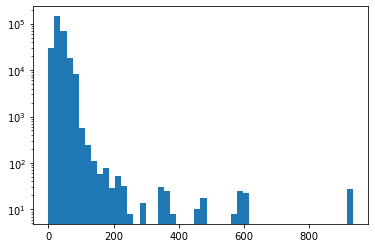

In [16]:
plt.hist(distances, log = True, bins = 50)
plt.show()

In [17]:
sentence_citation = sentence_citation.assign(
    distance = distances, 
    sentence_length = lambda df: df.sentence_words.map(len)
)\
.assign(wer = lambda df: df.distance / df.sentence_length)\

show(sentence_citation)

(271295, 9)


,reference_id,paper_id,sentence,text,sentence_words,citation_words,distance,sentence_length,wer
0,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Regarding, textual, context, ,, we, evaluated...",21,7,3.000000
1,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Evaluating, the, recent, dense, word, embeddi...",23,7,3.285714
2,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Evaluating, the, recent, dense, word, embeddi...",23,7,3.285714
3,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[2013, [, 134, ], ✗, ✓, (, Wikipedia, Text, ),...",20,7,2.857143
4,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Within, Distributional, methods, ,, we, intro...",38,7,5.428571


In [18]:
sentence_citation.wer.describe()

count    271295.000000
mean         12.414047
std          15.709022
min           0.000000
25%           1.086957
50%           2.761905
75%          22.000000
max          84.000000
Name: wer, dtype: float64

<AxesSubplot:ylabel='Frequency'>

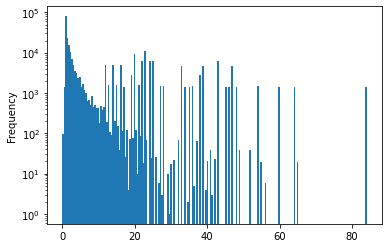

In [19]:
sentence_citation.wer.plot.hist(bins = 200, log = True)

<AxesSubplot:ylabel='Frequency'>

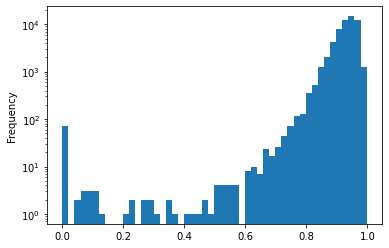

In [20]:
sentence_citation.query("wer < 1").wer.plot.hist(bins = 50, log = True)

In [21]:
sentence_citation\
.query("wer < 0.6")\
.sort_values("wer", ascending = False)\
.shape

(118, 9)

In [22]:
sentence_citation\
.query("wer < 0.5")\
.sort_values("wer", ascending = False)\
.shape

(102, 9)

In [23]:
sentence_citation\
.query("wer < 0.4")\
.sort_values("wer", ascending = False)\
.shape

(96, 9)

In [24]:
sentence_citation\
.query("wer < 0.2")\
.sort_values("wer", ascending = False)\
.shape

(85, 9)

In [25]:
sentence_citation = sentence_citation.assign(relevant = lambda df: df.wer < 0.5)
show(sentence_citation)

(271295, 10)


,reference_id,paper_id,sentence,text,sentence_words,citation_words,distance,sentence_length,wer,relevant
0,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Regarding, textual, context, ,, we, evaluated...",21,7,3.000000,False
1,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Evaluating, the, recent, dense, word, embeddi...",23,7,3.285714,False
2,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Evaluating, the, recent, dense, word, embeddi...",23,7,3.285714,False
3,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[2013, [, 134, ], ✗, ✓, (, Wikipedia, Text, ),...",20,7,2.857143,False
4,0,84,0,List of Abbreviations and Symbols Used .,"[List, of, Abbreviations, and, Symbols, Used, .]","[Within, Distributional, methods, ,, we, intro...",38,7,5.428571,False


In [26]:
task_labels = sentence_citation.groupby(["paper_id", "sentence", "reference_id"])\
.relevant.sum()\
.map(lambda x: x > 0)\
.reset_index()\
.merge(task_sentences)\
.assign(sentence_words = lambda df: df.sentence_words.map(len))

show(task_labels)

(27140, 6)


,paper_id,sentence,reference_id,relevant,text,sentence_words
0,12,0,19,False,1041-4347 (c) 2020 IEEE.,7
1,12,1,19,False,"Personal use is permitted, but republication/r...",11
2,12,2,19,False,See http://www.ieee.org/publications_standards...,8
3,12,3,19,False,"Index Terms—Natural language processing, named...",45
4,12,4,19,False,NER not only acts as a standalone tool for inf...,82


In [27]:
task_labels.query("relevant == True").groupby(["reference_id", "paper_id"]).size() \
/ task_pool.set_index(["reference_id", "paper_id"]).mentions

reference_id  paper_id
0             84          0.714286
1             482         0.437500
2             817         0.857143
3             1031        0.500000
4             302         0.750000
5             405         0.400000
6             1031        0.875000
7             380         0.857143
8             1031        0.700000
9             722         0.833333
10            979         1.000000
11            926         0.714286
12            213         0.666667
13            38          0.600000
14            715         0.666667
15            217         0.857143
16            578         0.600000
17            14          0.800000
18            482         0.800000
19            12          0.571429
dtype: float64

# sanity check

In [28]:
ref = 2
paper = 817

In [29]:
references.title[ref], papers.title[paper]

('Attention Is All You Need', 'Self-Attentive Hawkes Process')

In [30]:
citations.query("reference_id == @ref and paper_id == @paper")\
.context\
.str.replace(r"\s*\[.+?\]", "", regex = True)\
.tolist()

['These query vectors are used to find which part of the input sequence is more contributory (Vaswani et al., 2017).',
 'Self-attention is a special case of the attention mechanism (Vaswani et al., 2017), where the query vectors Q, like (K,V ), are from the encoder side.',
 'Self-attention is very expressive and flexible for both longterm and local dependencies, which used to be modeled by recurrent neural networks (RNNs) and convolutional neural networks (CNNs) (Vaswani et al., 2017).',
 'Recently, a variety of Natural Language Processing (NLP) tasks have experienced large improvements thanks to self-attention (Vaswani et al., 2017; Devlin et al., 2018).',
 'This allows the model to jointly attend information from different representation subspaces (Vaswani et al., 2017).',
 'coding is replaced with the standard one as in (Vaswani et al., 2017).',
 'However, RNN and its variants have been empirically proved to be less competent than self-attention in NLP (Vaswani et al., 2017; Devlin 

In [31]:
task_labels\
.query("reference_id == @ref and paper_id == @paper and relevant == True")\
.text\
.str.replace(r"\s*\[.+?\]", "", regex = True)\
.tolist()

['These query vectors are used to find which part of the input sequence is more contributory (Vaswani et al., 2017).',
 'Self-attention is a special case of the attention mechanism (Vaswani et al., 2017), where the query vectors Q, like (K,V ), are from the encoder side.',
 'Self-attention is very expressive and flexible for both longterm and local dependencies, which used to be modeled by recurrent neural networks (RNNs) and convolutional neural networks (CNNs) (Vaswani et al., 2017).',
 'Recently, a variety of Natural Language Processing (NLP) tasks have experienced large improvements thanks to self-attention (Vaswani et al., 2017; Devlin et al., 2018).',
 'This allows the model to jointly attend information from different representation subspaces (Vaswani et al., 2017).',
 'However, RNN and its variants have been empirically proved to be less competent than self-attention in NLP (Vaswani et al., 2017; Devlin et al., 2018).']

# dataset

In [32]:
positive_sentences = task_labels.query("relevant == True")
show(positive_sentences)

(100, 6)


,paper_id,sentence,reference_id,relevant,text,sentence_words
304,12,304,19,True,The use of neural models for NER was pioneered...,29
344,12,344,19,True,[17] proposed a sentence approach network wher...,25
479,12,479,19,True,Many deep learning based NER models use a CRF ...,59
568,12,568,19,True,[17] trained a window/sentence approach networ...,21
768,14,3,17,True,These tasks include sentence-level tasks such ...,90


In [33]:
sample_size = (30 - task_labels.query("relevant == True").groupby(["reference_id", "paper_id"])\
               .size()).reset_index()
sample_size

,reference_id,paper_id,0
0,0,84,20
1,1,482,23
2,2,817,24
3,3,1031,25
4,4,302,27
5,5,405,28
6,6,1031,23
7,7,380,24
8,8,1031,23
9,9,722,25


In [34]:
negative_samples = []
for ref, paper, size in sample_size.values:
    negative_samples.append(
        task_labels\
        .query(f"relevant == False and reference_id == {ref} and paper_id == {paper} and sentence_words > 5")\
        .sample(n = size)
    )
negative_sentences = pd.concat(negative_samples)
show(negative_sentences)

(500, 6)


,paper_id,sentence,reference_id,relevant,text,sentence_words
7362,84,6033,0,False,"For the avoidance of doubt, Springer has the r...",26
5738,84,4409,0,False,"NGED, similar to edit distance of strings, tri...",33
6209,84,4880,0,False,LambdaMart is a list-wise approach that aims t...,14
4695,84,3366,0,False,4 2.1 Word2vec embedding: CBOW vs Skip-gram .,9
6450,84,5121,0,False,Section 3.6.1 7. rvsPagerank: cosine similarit...,13


In [35]:
tasks = pd.concat((positive_sentences, negative_sentences))\
.sort_values(["reference_id", "paper_id", "sentence"])

show(tasks)

(600, 6)


,paper_id,sentence,reference_id,relevant,text,sentence_words
4695,84,3366,0,False,4 2.1 Word2vec embedding: CBOW vs Skip-gram .,9
5079,84,3750,0,False,xv Chapter 1 Introduction “Concepts1 are the c...,16
5148,84,3819,0,False,We refer to this entity as the key entity.,10
5161,84,3832,0,True,"Regarding textual context, we evaluated multip...",23
5207,84,3878,0,False,This relation can be the well known taxonomic ...,42


In [36]:
tasks.groupby("paper_id").size()

paper_id
12      30
14      30
38      30
84      30
213     30
217     30
302     30
380     30
405     30
482     60
578     30
715     30
722     30
817     30
926     30
979     30
1031    90
dtype: int64

In [37]:
tasks.groupby("reference_id").size()

reference_id
0     30
1     30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
12    30
13    30
14    30
15    30
16    30
17    30
18    30
19    30
dtype: int64

In [38]:
ref = 1

In [39]:
references.title[ref], references.abstract[ref]

('BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding',
 'We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test

In [40]:
tasks\
.query(f"reference_id == {ref}")\
.assign(clean_text = lambda df: df.text.str.replace(r"\s*\[.+?\]", "", regex = True))\
[["relevant", "clean_text"]].values

array([[False,
        'The computational costs of inference with transformers has led to alternatives and variants that aim for different tradeoffs, both within multi-stage architectures as well as with dense learned representations.'],
       [True,
        'This survey provides an overview of text ranking with a family of neural network models known as transformers, of which BERT (Bidirectional Encoder Representations from Transformers), an invention of Google, is the best-known example.'],
       [False,
        'We give this example because it is easy to convey, but the general idea of using heuristics to automatically gather training examples to train a classifier in NLP dates back to Yarowsky, in the context of word sense disambiguation.13 Data augmentation refers to techniques that exploit a set of training examples to gather or create additional training examples.'],
       [True, 'BERT arrived on the scene in October 2018.'],
       [False,
        'If a relevant document doe

In [42]:
print(
    tasks\
    .sample(frac = 1)\
    .groupby("reference_id")\
    .text\
    .agg(lambda x: "\n\n".join(x))\
    [1]
)

The authors called this model TCT-ColBERT, where TCT stands for “Tightly Coupled Teacher”.

While the original paper [Devlin et al., 2019] presented only the BERTBase and BERTLarge configurations, with 12 and 24 transformer encoder layers, respectively, in later work Turc et al.

These gains are only 117In the original BERT paper [Devlin et al., 2019], embeddings from this layer were more effective for named entity recognition than embeddings from the twelfth (last) layer (see Table 7).

More generally, it is almost never reported in papers how many different techniques the researchers had tried before obtaining a positive result.

Currently, we still lack definitive answers, but this represents an interesting future direction worth exploring.

demonstrated the effectiveness of multi-vector representational approaches, the effectiveness of ME-BERT appears to lag behind other dense retrieval techniques in absolute terms.

, p cls n [i]).

The computational costs of inference with transf